*Alumno: Alejandro Pérez Candela*

*Lab 6 - Técnicas de optimización de entrenamiento*

#  Técnicas de optimización de entrenamiento

## 0. Importación de librerías necesarias

In [3]:
import pandas as pd
import numpy as np
import re
import os
import random

from matplotlib import pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Descargar recursos necesarios para NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, BatchNormalization, Flatten, GlobalAveragePooling1D 
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ALEX\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ALEX\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ALEX\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### 0.1. Fijar random seed:

In [4]:
# Fijar la semilla aleatoria para reproducibilidad
SEED_VALUE = 42
tf.random.set_seed(SEED_VALUE)  # Semilla de TensorFlow
np.random.seed(SEED_VALUE)  # Semilla de NumPy
random.seed(SEED_VALUE)  # Semilla de Python
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)  # Semilla para hash de Python para reproducibilidad

## 1. Carga del archivo CSV y análisis exploratorio de los datos

In [5]:

file_path = 'IMDB Dataset.csv'
df = pd.read_csv(file_path)

# Exploración inicial del DataFrame para entender la estructura
df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
# Mostrar la cantidad de valores nulos por columna
print("Cantidad de valores nulos por columna:")
print(df.isnull().sum())

Cantidad de valores nulos por columna:
review       0
sentiment    0
dtype: int64


## 2. Preprocesamiento y limpieza del dataset

In [7]:
# Preprocesar las reseñas (reviews)
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [8]:
# Definimos una función para limpiar las sinopsis
def preprocess_text(text):
    # Eliminar etiquetas HTML
    text = re.sub(r'<.*?>', '', text)
    
    # Convertir a minúsculas
    text = text.lower()
    
    # Reemplazar contracciones
    contractions = {
        "can't": "cannot",
        "won't": "will not",
        "n't": " not",
        "'re": " are",
        "'s": " is",
        "'d": " would",
        "'ll": " will",
        "'t": " not",
        "'ve": " have",
        "'m": " am"
    }
    for contraction, full_form in contractions.items():
        text = re.sub(contraction, full_form, text)
    
    # Eliminar caracteres especiales y números
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    
    # Eliminar espacios extra
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenizar y eliminar stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    # Lematizar
    words = [lemmatizer.lemmatize(word, pos='v') for word in words]
    
    return ' '.join(words)

In [9]:
df['review'] = df['review'].apply(preprocess_text)

In [10]:
# Filtrar solo las clases 'Positive' y 'Negative'
df_filtered = df[df['sentiment'].isin(['positive', 'negative'])]

In [11]:
# Mapear la columna 'sentiment' a valores numéricos
df_filtered['sentiment'] = df_filtered['sentiment'].map({'positive': 1, 'negative': 0})

In [12]:
df_filtered.head()

,review,sentiment
0,one reviewers mention watch oz episode hook ri...,1
1,wonderful little production film technique una...,1
2,think wonderful way spend time hot summer week...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stun fi...,1


In [13]:
# Guardar el dataset limpiado a un archivo CSV
cleaned_file_path = "IMDB_Dataset_Cleaned.csv"
df_filtered.to_csv(cleaned_file_path, index=False)

## 3. Tokenización y creación de secuencias

In [14]:
# Definir el tamaño del vector de embeddings
VECTOR_SIZE = 100

In [15]:
# Tokenizar los textos para Word2Vec
reviews_tokenized = [review.split() for review in df_filtered['review']]

In [16]:
# Entrenar el modelo Word2Vec
word2vec_model = Word2Vec(sentences=reviews_tokenized, vector_size=VECTOR_SIZE, window=5, min_count=1, workers=4)

In [17]:
# Calcular la similitud del coseno entre los vectores de las palabras (opcional, para análisis exploratorio)
words = list(word2vec_model.wv.index_to_key)
word_vectors = tf.convert_to_tensor([word2vec_model.wv[word] for word in words], dtype=tf.float32)
similarity_matrix = tf.keras.losses.cosine_similarity(word_vectors, word_vectors)

In [18]:
similarity = word2vec_model.wv.similarity('clear', 'light')
print(f"Similitud entre 'clear' and 'light': {similarity}\n")

similarity = word2vec_model.wv.similarity('good', 'great')
print(f"Similitud entre 'good' and 'great': {similarity}\n")

similarity = word2vec_model.wv.similarity('fuck', 'shit')
print(f"Similitud entre 'fuck' and 'shit': {similarity}\n")

similarity = word2vec_model.wv.similarity('hate', 'love')
print(f"Similitud entre 'hate' and 'love': {similarity}")


Similitud entre 'clear' and 'light': 0.2521263659000397

Similitud entre 'good' and 'great': 0.7413163185119629

Similitud entre 'fuck' and 'shit': 0.5777925848960876

Similitud entre 'hate' and 'love': 0.5596263408660889


In [19]:
# Find the 5 most similar words to 'hate'
try:
    similar_words = word2vec_model.wv.most_similar('nice', topn=5)
    print("5 palabras más similares a 'nice':")
    for word, similarity in similar_words:
        print(f"{word}: {similarity}")
except KeyError:
    print("'love' is not in the vocabulary.")

5 palabras más similares a 'nice':
neat: 0.7156485319137573
cool: 0.6920239329338074
good: 0.6667721271514893
guyslook: 0.6340630650520325
odd: 0.6062539219856262


In [20]:
# Tokenizar los textos y convertirlos a secuencias
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df_filtered['review'])
X = tokenizer.texts_to_sequences(df_filtered['review'])

In [21]:
# Rellenar las secuencias para que tengan la misma longitud
max_sequence_length = max(len(seq) for seq in X)
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=max_sequence_length)

In [22]:
# Dividir en conjuntos de entrenamiento y validación primero removiendo la etiqueta
y = df_filtered['sentiment'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Preparar la matriz de embeddings
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, VECTOR_SIZE))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

In [24]:
embedding_matrix.shape

(195207, 100)

## 4. Definir el modelo

### Funciones que utilizaremos:

In [ ]:
# Función para graficar valores de entrenamiento y validación
def graficar_entrenamiento(histories, labels, colors):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    for history, label, color in zip(histories, labels, colors):
        axes[0].plot(history.history['accuracy'], color=color, linestyle='-', label=f'{label} Train')
        axes[0].plot(history.history['val_accuracy'], color=color, linestyle='--', label=f'{label} Validation')
    axes[0].set_title('Training & Validation Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    
    for history, label, color in zip(histories, labels, colors):
        axes[1].plot(history.history['loss'], color=color, linestyle='-', label=f'{label} Train')
        axes[1].plot(history.history['val_loss'], color=color, linestyle='--', label=f'{label} Validation')
    axes[1].set_title('Training & Validation Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Método para probar el modelo con una nueva reseña
def probar_modelo(reseña):
    reseña_procesada = preprocess_text(reseña)
    secuencia = tokenizer.texts_to_sequences([reseña_procesada])
    secuencia_padded = tf.keras.preprocessing.sequence.pad_sequences(secuencia, maxlen=max_sequence_length)
    prediccion = model.predict(secuencia_padded)
    if prediccion >= 0.5:
        print("Reseña positiva")
    else:
        print("Reseña negativa")

In [ ]:
# Función para mostrar la matriz de confusión del modelo
def mostrar_matriz_confusion(modelo, X_val, y_val):
    y_pred = (modelo.predict(X_val) >= 0.5).astype(int)
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

### 4.1. Comenzamos con el modelo más simple:

In [ ]:
# Definir un modelo simplista
model_simple = Sequential()
model_simple.add(Embedding(input_dim=len(tokenizer.word_index) + 1, 
                    output_dim=VECTOR_SIZE, 
                    weights=[embedding_matrix], 
                    input_length=max_sequence_length, 
                    trainable=True))
model_simple.add(Flatten())
model_simple.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model_simple.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Entrenar el nuevo modelo
simple_history = model_simple.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

In [ ]:
graficar_entrenamiento([simple_history], ['modelo simple'], ['b'])

## Conclusiones:

Hay un overfiting muy marcado que puede verse en los datos de validación. 

### 4.2. Reducir el overfitting

#### 4.2.1 Probemos con una capa Dropout:

Utilizaremos una única capa de Dropout al 30%, es bastante porcentaje pero visto el gran overfitting que tenemos...

In [ ]:
# Definir un nuevo modelo para reducir el overfitting
model_dropout = Sequential()
model_dropout.add(Embedding(input_dim=len(tokenizer.word_index) + 1, 
                    output_dim=VECTOR_SIZE, 
                    weights=[embedding_matrix], 
                    input_length=max_sequence_length, 
                    trainable=True))
model_dropout.add(Flatten())
model_dropout.add(Dropout(0.3))  # Añadido Dropout para reducir overfitting
model_dropout.add(Dense(1, activation='sigmoid'))

# Compilar el nuevo modelo
model_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

NameError: name 'Sequential' is not defined

In [ ]:
# Entrenar el nuevo modelo
dropout_history = model_dropout.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 261s 208ms/step - accuracy: 0.7664 - loss: 0.5653 - val_accuracy: 0.8391 - val_loss: 0.4859
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 269s 215ms/step - accuracy: 0.8737 - loss: 0.3607 - val_accuracy: 0.8506 - val_loss: 0.5285
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 255s 204ms/step - accuracy: 0.9135 - loss: 0.2425 - val_accuracy: 0.8440 - val_loss: 0.6281
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 272s 218ms/step - accuracy: 0.9401 - loss: 0.1688 - val_accuracy: 0.8515 - val_loss: 0.6548
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 237s 190ms/step - accuracy: 0.9523 - loss: 0.1399 - val_accuracy: 0.8492 - val_loss: 0.7625
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 209s 168ms/step - accuracy: 0.9645 - loss: 0.0981 - val_accuracy: 0.8530 - val_loss: 0.8306
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 204s 163ms/step - accuracy: 0.9713 - loss: 0.0872 - val_accuracy: 0.8565 - val_loss: 0.8721
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 208s 166ms/step - ac

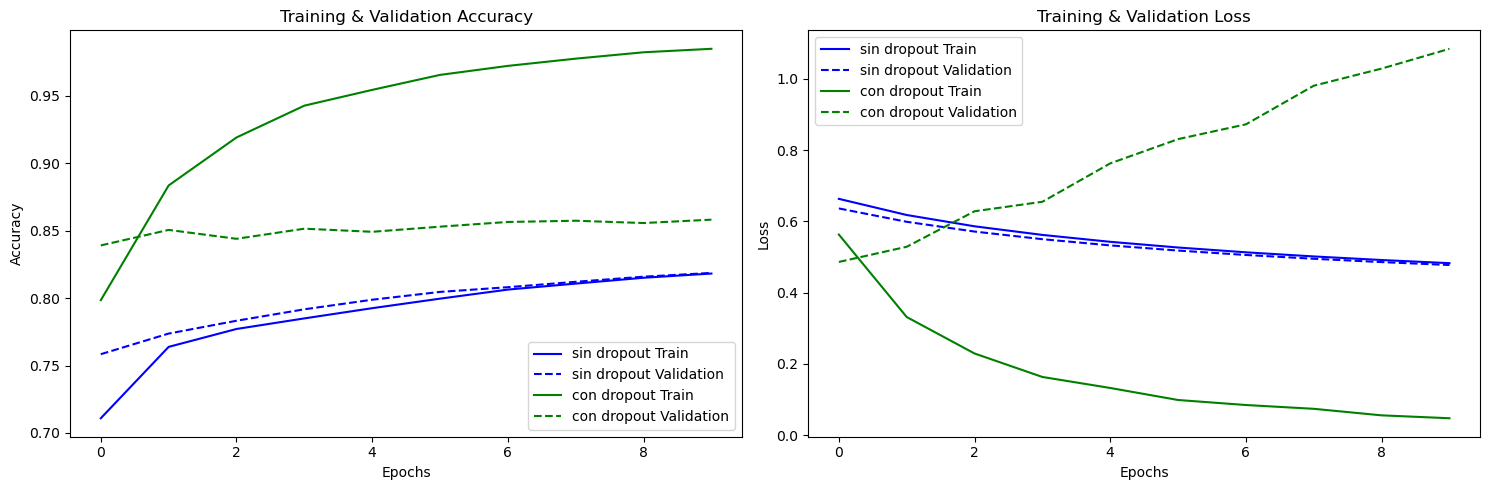

In [ ]:
graficar_entrenamiento([simple_history, dropout_history], ['sin dropout', 'con dropout'], ['b', 'g'])

El overfiting se ha reducido un poco como era de esperar, pero no del todo ni mucho menos. Además, está penalizando mucho el entrenamiento. Se necesitarían muchas más épocas, lo que resultaría ineficiente, y seguiría teniendo un grave problema de overfiting.

#### 4.2.2 Probemos con una capa GlobalAveragePooling1D

In [26]:
# Definir un modelo simple de red neuronal
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=VECTOR_SIZE, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model.add(GlobalAveragePooling1D())
model.add(Dense(1, activation='sigmoid'))

c:\Users\ALEX\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [27]:
# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6428 - loss: 0.6775 - val_accuracy: 0.7584 - val_loss: 0.6360
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7531 - loss: 0.6282 - val_accuracy: 0.7737 - val_loss: 0.5986
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7700 - loss: 0.5947 - val_accuracy: 0.7832 - val_loss: 0.5712
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7786 - loss: 0.5695 - val_accuracy: 0.7917 - val_loss: 0.5497
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7872 - loss: 0.5495 - val_accuracy: 0.7988 - val_loss: 0.5323
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7949 - loss: 0.5331 - val_accuracy: 0.8046 - val_loss: 0.5178
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8015 - loss: 0.5193 - val_accuracy: 0.8081 - val_loss: 0.5054
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8060 - loss: 0.5074 - 

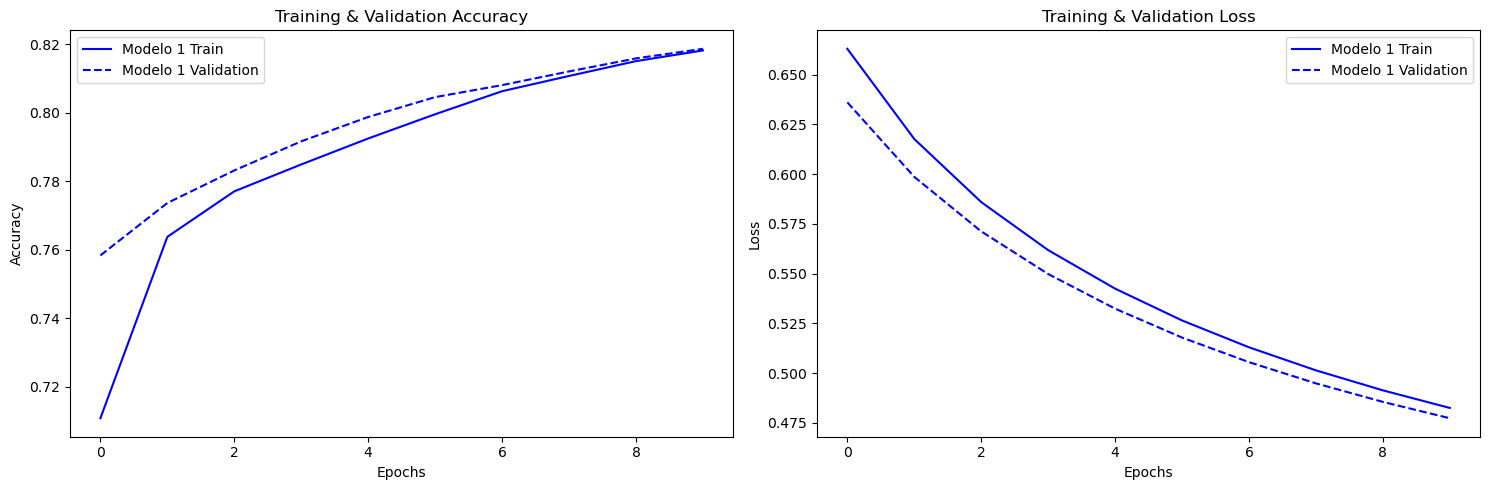

In [30]:
# Graficar resultados del modelo
graficar_entrenamiento([history], ['Modelo 1'], ['blue'])

In [32]:

# Probar el modelo con una reseña
probar_modelo("love")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Reseña positiva


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


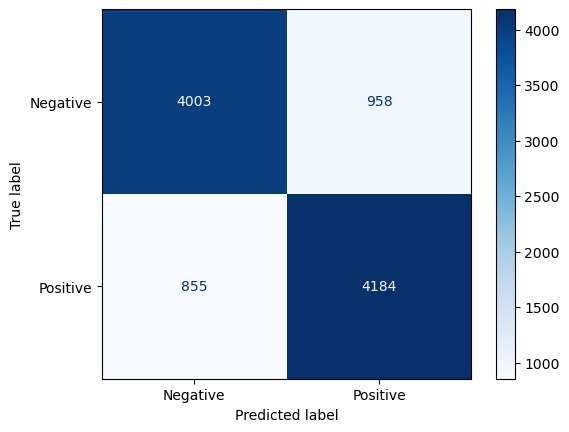

In [34]:
# Mostrar la matriz de confusión del modelo
mostrar_matriz_confusion(model, X_val, y_val)

### Conclusiones sobre la reducción de overfitting:

Gracias a la capa de GlobalAveragePooling1D sí hemos conseguido eliminar el overfitting. Ahora que nuestro modelo es "medio decente", es hora de probar con diferentes batch sizes.

### 4.3 Probar con diferentes batch sizes

In [35]:
history_16 = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val, y_val))

history_64 = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

history_128 = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val))

history_256 = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_val, y_val))

Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8181 - loss: 0.4790 - val_accuracy: 0.8225 - val_loss: 0.4658
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8232 - loss: 0.4685 - val_accuracy: 0.8260 - val_loss: 0.4570
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8259 - loss: 0.4601 - val_accuracy: 0.8285 - val_loss: 0.4493
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8283 - loss: 0.4528 - val_accuracy: 0.8302 - val_loss: 0.4427
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.8300 - loss: 0.4465 - val_accuracy: 0.8316 - val_loss: 0.4368
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.8315 - loss: 0.4408 - val_accuracy: 0.8337 - val_loss: 0.4316
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.8328 - loss: 0.4359 - val_accuracy: 0.8364 - val_loss: 0.4269
Epoch 8/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.8337 - loss: 0.43

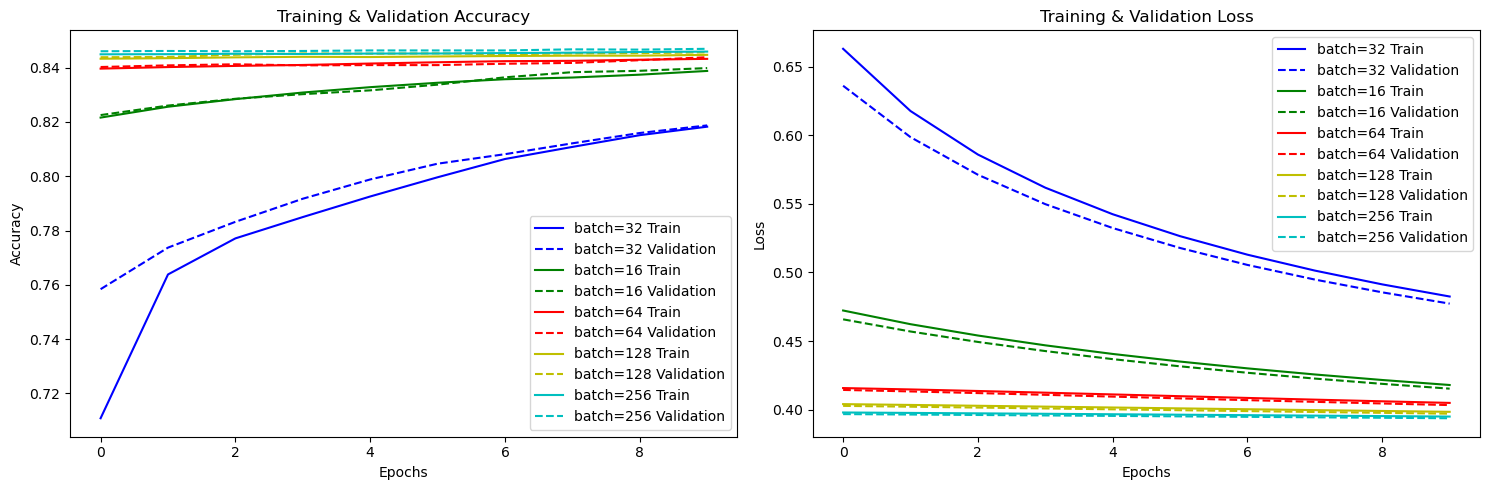

In [36]:
graficar_entrenamiento([history, history_16, history_64, history_128, history_256,], ['batch=32', 'batch=16', 'batch=64', 'batch=128', 'batch=256'], ['b', 'g', 'r', 'y', 'c'])